# Product Recognition on Store Shelves
## Computer Vision and Image Processing - Exam Project
### Letizia Mancini, letizia.mancini3@studio.unibo.it

### Environment setup 

In [1]:
import numpy as np
import cv2
import math
from matplotlib import pyplot as plt

# image directories
scene_dir = 'scenes'
product_dir = 'models'
# image names
scene_images = ['m1.png', 'm2.png', 'm3.png', 'm4.png', 'm5.png']
product_images = ['0.jpg', '1.jpg', '11.jpg', '19.jpg', '24.jpg', '26.jpg', '25.jpg']

img_train = []
img_query = [] 

In [2]:
## utils
def barycentre(keypoints):
    x = 0
    y = 0
    
    for kp in keypoints:
        x += kp.pt[0]
        y += kp.pt[1]
        
    x = x/len(keypoints)
    y = y/len(keypoints)
    
    return (x, y)        

In [3]:
class KeyPoint:
    def __init__(self, pc, kp, dest):
        self.vi = (pc[0] - kp.pt[0], pc[1] - kp.pt[1])
        self.kp = kp
        self.dest = dest    

#### Loading the images

In [10]:
# read the images
    
# load the query images
for i in range(len(product_images)):
    product_images[i] = product_dir + "/" + product_images[i]
    img_query.append( cv2.imread(product_images[i], cv2.IMREAD_GRAYSCALE) ) # queryImage


### Offline phase
local invariant feature together with the GHT

#### 1. Keypoint Detection
Initialize the SIFT detector object in the following way:

In [5]:
# Creating SIFT object
sift = cv2.xfeatures2d.SIFT_create(nOctaveLayers=5, contrastThreshold=0.10, sigma=1.5)

Then we need to find keypoints. We will use detect method of the SIFT detector object. Let us find the keypoints of the query image:

In [6]:
# find the keypoints and descriptors with SIFT
kp_query = []

for img in img_query:
    kp_query.append(sift.detect(img))
    # Number of keypoints
    print(len(kp_query))

1
2
3
4
5
6
7


#### 2. Keypoints Description 

Compute for each keypoint a unique description usually based on the nearby pixels (descriptor support).
We will use the SIFT descriptor for this sample study. We can use the same SIFT detector object calling the *compute* method:

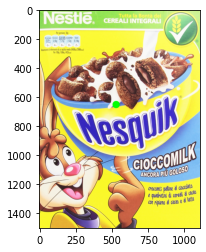

barycentre in (529.75, 650.18)


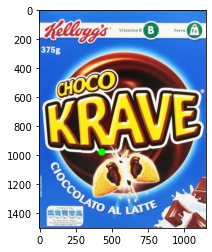

barycentre in (431.35, 977.06)


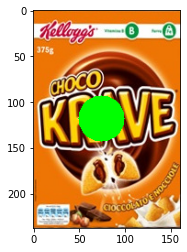

barycentre in (74.13, 118.00)


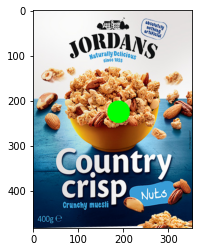

barycentre in (189.24, 225.31)


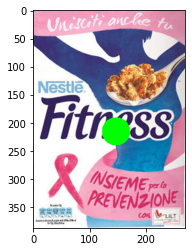

barycentre in (147.08, 215.85)


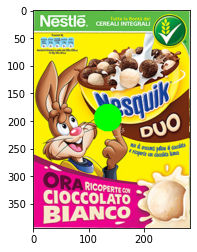

barycentre in (135.75, 194.29)


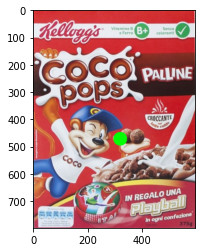

barycentre in (318.47, 471.36)


In [9]:
# Describing keypoints for query and train images 
## array perché lista mi dava errori sugli indici
des_query = np.empty(len(img_query), dtype=object)
kp_query_extended = []
img_query_rgb = [] ## immagini a colori

for img in product_images:
    img_query_rgb.append(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB))


for i in range(len(img_query)):
    kp_query[i], des_query[i] = sift.compute(img_query[i], kp_query[i])
    
    # calcolo il baricentro
    pc = barycentre(kp_query[i])
    kp_query_extended.append([])
    for k in range(len(kp_query[i])):
        kp_query_extended[i].append(KeyPoint(pc, kp_query[i][k], des_query[i][k]))
    
    centre_coordinates = (np.int32(pc[0]), np.int32(pc[1]))
    img_query_rgb[i] = cv2.circle(img_query_rgb[i], centre_coordinates, radius=25, color=(0,255,0), thickness=-1)
    plt.imshow(img_query_rgb[i])
    plt.show()
    print(f'barycentre in ({pc[0]:.2f}, { pc[1]:.2f})')
    


### Online phase

Load the target images

In [11]:
# load the train images (da fare ONLINE)
for i in range( len(scene_images) ):
    scene_images[i] = scene_dir + "/" + scene_images[i]
    img_train.append( cv2.imread(scene_images[i], cv2.IMREAD_GRAYSCALE) ) # trainImage

#### 3. Scene Keypoint Detection
Initialize the SIFT detector object in the following way:

In [12]:
# find the keypoints and descriptors with SIFT
kp_train = []

for img in img_train:
    kp_train.append(sift.detect(img))
    # Number of keypoints
    print(len(kp_train))

1
2
3
4
5


In [13]:
# Describing keypoints for query and train images 
## array perché lista mi dava errori sugli indici
des_train = np.empty(len(img_train), dtype=object)

for i in range(len(img_train)):
    kp_train[i], des_train[i] = sift.compute(img_train[i], kp_train[i])

#### 4. Match with Query Images
Match descriptors between target and model features

In [14]:
# Defining index for approximate kdtree algorithm
FLANN_INDEX_KDTREE = 1

# Defining parameters for algorithm 
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

# Defining search params.
# checks=50 specifies the number of times the trees in the index should be recursively traversed.
# Higher values gives better precision, but also takes more time (try 500)
search_params = dict(checks = 500)

# Initializing matcher
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching and finding the 2 closest elements for each query descriptor.
# in each scene i search the match for each cereal box
image_matches = np.empty(len(img_train), dtype=object) # img train = le scene
i = 0

# match tra i descrittori delle scene e delle scatole
for j in des_train:
    image_matches[i] = [] # lista per i match di ogni train images
    for k in des_query:
        image_matches[i].append(flann.knnMatch(k, j, k=2))
    i += 1

In [15]:
good = np.empty(len(image_matches), dtype=object)
i = 0

for match_list in image_matches:
    good[i] = np.empty(len(img_query), dtype=object)
    j = 0
    for matches in match_list:
        good[i][j] = []
        for m,n in matches:
            if m.distance < 0.7*n.distance:
                good[i][j].append(m)
        j += 1
    i += 1